## find_telluric

**Author:** Felipe Navarete (<felipe.navarete@noirlab.edu>)

**Date:** 2024-02-09

**Version:** 1.0


This Python notebook will search for early A-type stars close to a given (RA, Dec) that could be used as a telluric standard star for NIR spectroscopic observations.

It's defined to be used for the [SOAR telescope](https://noirlab.edu/public/programs/ctio/soar-telescope/) (also works for [Rubin](https://rubinobservatory.org/), [Gemini South](https://noirlab.edu/public/es/programs/gemini-observatory/gemini-south/) and [CTIO](https://noirlab.edu/science/programs/ctio) telescopes), but it can be easily adapted for any other facility.

### 1. Import libraries
This code uses Astroquery, Astropy, Matplotlib, Numpy, Pandas, IPython and RE libraries

In [4]:
from   astroquery.simbad import Simbad
import astropy.coordinates as coord
from   astropy.coordinates import AltAz, EarthLocation, SkyCoord, get_sun, get_body
from   astropy.table import Table
from   astropy.time import Time
import astropy.units as u
from   astropy.visualization import astropy_mpl_style, quantity_support
from   datetime import datetime, timedelta
from   IPython.display import HTML
import matplotlib.pyplot as plt
from   matplotlib.patheffects import withStroke
from   matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
import pytz
import re
from scipy.interpolate import interp1d


print("Imports were done.")

Imports were done.


### 2. Load the functions

In [7]:
def find_telluric(coords, max_hour=0.5, max_sep=10., mag_lim=[5.0,7.5], band='K', AXVstars=(0,1,2), localtime_obs=None, dairmass=None,
                  n_digits=3, debug=False, html=True,
                  show_url=True, date_obs=False, plot_visibility=False):
    """
      Find_Telluric() will query for early A-type stars (A0V to A2V)
      around a given position on the sky (RA, Dec) 
      to be used as telluric standard stars for NIR spectroscopic observations.
      The Query does not exclude Binaries or other type of objects,
      so you still have to inspect the results yourself to make sure you are selecting isolated stars for your observations.
    
      Args:

        coords [string]: Right Ascension and Declination (in 'hh:mm:ss.ss' and 'dd:mm:ss.ss' format)
        
        max_hour [float, default=0.5]: maximum distance in RA between the given position and the standard star (in hours)
        
        max_sep [float, default=10.]: maximum separation between the given position and the standard star (in degrees)
        
        mag_lim (float, default=[5.0,7.5]): select stars with magnitudes within a given interval: [fainter than, brighter than] 
        
        band (string, default='K'): band to apply the mag_lim filter. Accepted values: [B, V, J, H, K]
        
        AXVstars (int, default=(0,1,2)): provide the spectral subtypes (AXV, X=0,1,2,...) to search for. Works with a single int value or a list of ints.

        n_digits (int, default=3): number of digits to show on the results
        
        debug (bool, default = False): print intermediary results on screen
        
        html (bool, default = True): display results as an HTML table (with hyperlinks)
        
        show_url (bool, default = True): show URLs for Simbad
        
        date_obs (string, default=False): 

        plot_visibility (bool, default = True): show the visibility plot
        
    """
    
    # split string into separate ra and dec variables
    ra, dec = split_coords(coords)
    
    # transform RA and Dec into astropy coordinates
    coordinates = coord.SkyCoord(ra + dec, unit=(u.hourangle, u.deg), frame='icrs')

    # create a string for querying the Simbad database for specific spectral subtypes
    txt_axv = query_a_stars(AXVstars)
    
    
    # type 1 query - use ranges of ra and dec - max_hour is in hours and max_sep in degrees
    query = ("( rah >= "+str(coordinates.ra.hour-max_hour)+" & rah <= "+str(coordinates.ra.hour+max_hour)+" ) & "
             "( dec >= "+str(coordinates.dec.deg-max_sep)+" & dec < "+str(coordinates.dec.deg+max_sep)+" ) & "
             "( "+str(band)+"mag <= "+str(max(mag_lim))+" &  "+str(band)+"mag >= "+str(min(mag_lim))+" ) & "
             "cat='HIP' & " + txt_axv
             #"( sptype ='A0V' | sptype ='A1V' | sptype ='A2V')"
             #"( sptype ='A0V' | sptype ='A1V' | sptype ='A2V'| sptype ='A3V'| sptype ='A4V' )"
            )
    
    if debug:
        print("Query (copy and paste into [http://simbad.cds.unistra.fr/simbad/sim-fsam]):")
        print(query)
        print("")
    
    # get the necessary fields from Simbad [http://simbad.u-strasbg.fr/Pages/guide/sim-fscript.htx]
    customSimbad = Simbad()
    customSimbad.TIMEOUT=180. # increase the TIMEOUT to 3 min to avoid conflicts (not sure it will work).
    customSimbad.add_votable_fields('id(HIP)','sptype', 'flux(B)', 'flux(V)','flux(V)','flux(J)', 'flux(J)', 'flux(H)', 'flux(K)', 'bibcodelist(1800-2023)')

    # run the query
    result_table = customSimbad.query_criteria(query)
    
    # check if the query was successfull
    if result_table is None:
        print("No entries.")
        return

    # for debugging, print all columns from the results
    #result_table.pprint_all()
    
    # exclude keywords that are not useful for the purpose
    result_table.remove_columns(['MAIN_ID','RA_PREC','DEC_PREC','COO_ERR_MAJA','COO_ERR_MINA','COO_ERR_ANGLE','COO_QUAL','COO_WAVELENGTH','COO_BIBCODE',
                                 'SP_QUAL', 'SP_BIBCODE','SCRIPT_NUMBER_ID'])

    # Make the HIP name the first column of the table
    hip_col = result_table['ID_HIP']
    result_table.remove_column('ID_HIP')
    result_table.add_column(hip_col, name='ID_HIP', index=0)
    
    # Astropy Table -> Pandas DataFrame 
    pd_table = result_table.to_pandas()
    
    # now add new columns to the table
    sep_deg  = []
    dra_hour = []
    ra_format = []
    de_format = []
    obs_stat = []
    urls=[]
    
    for index, row in pd_table.iterrows():

        # transform RA and Dec into astropy coordinates
        coords = coord.SkyCoord(row["RA"],row["DEC"], unit=(u.hourangle, u.deg), frame='icrs')

        # format RA and Dec into "hms dms" strings
        formatted_ra  = coords.ra.to_string(unit=u.hourangle, sep=':', precision=2, pad=True)
        formatted_dec = coords.dec.to_string(unit=u.degree, sep=':', precision=2, alwayssign=True, pad=True)

        ra_format.append(formatted_ra)
        de_format.append(formatted_dec)

        # get the difference in hourangle
        delta_ra = coords.ra.hour - coordinates.ra.hour
        obs_txt = 'Before Science' if delta_ra < 0 else 'After Science'
        dra_hour.append(delta_ra)
        obs_stat.append(obs_txt)
        
        # get the separation in degrees
        sep = coords.separation(coordinates)
        sep_deg.append(sep.deg)
        
        # create the URL for Simbad
        url='https://simbad.cds.unistra.fr/simbad/sim-id?Ident='+str(row['ID_HIP']).replace(' ','+')
        urls.append(url)

    # now reorder the table
    pd_table['RA'] = ra_format
    pd_table['DEC'] = de_format
    pd_table['Sep_deg'] = sep_deg
    pd_table['dRA_hours'] = dra_hour
    pd_table['Status'] = obs_stat
    pd_table['URL_simple'] = urls
    
    # make sure to select only sources within the max_sep range
    pd_table = pd_table[ pd_table['Sep_deg'] <= max_sep ]
    
    # check if the query was successfull
    if len(pd_table) == 0:
        print("No entries.")
        return
    
    # sort results by dRA_hours
    pd_table = pd_table.sort_values(by=['dRA_hours'])
    
    pd_table['URL'] = pd_table['URL_simple'].apply(lambda x: f'<a href="{x}">{"Simbad"}</a>')
    
    # remove duplicated columns
    pd_table = pd_table.drop(['FLUX_V_1','FLUX_J_1'], axis=1)

    # Extract the selected column and remove it from the DataFrame
    if html is True:
        pd_table = pd_move_column(pd_table,'URL',1)
        pd_table = pd_table.drop('URL_simple', axis=1)
    else:
        pd_table = pd_table.drop('URL', axis=1)
        pd_table = pd_move_column(pd_table,'URL_simple',1,new_name='URL')
        
    if show_url is False: pd_table = pd_table.drop(['URL'],axis=1)
    
    pd_table.style
    
    # rename 'BIBLIST' to 'Refs'
    pd_table = pd_move_column(pd_table,'BIBLIST_1800_2023',5,new_name='Refs')
    pd_table = pd_move_column(pd_table,'dRA_hours',4)
    pd_table = pd_move_column(pd_table,'Status',5)
    
    # set number of digits for floats ('Sep_deg' and 'dRA_hours')
    pd.set_option('precision', n_digits)
    
    #return pd_table as HTML object or as a DataFrame (added index=False)
    table_out = HTML(pd_table.to_html(escape=False, index=False)) if html is True else pd_table.style.hide_index()
    
    # if date_obs is provided, plot the visibility chart
    if date_obs is not False:
        # Define a regular expression pattern to match the date format "YYYY-MM-DD"
        date_pattern = r'\d{4}-\d{2}-\d{2}'
        if re.match(date_pattern, date_obs):
            # Convert the DataFrame to a formatted string
            df_str = pd_table[['ID_HIP','RA','DEC']].copy()
            # Remove spaces from each entry in the DataFrame
            df_str['ID_HIP'] = df_str['ID_HIP'].str.replace(' ','')
            # from Pandas to string
            df_str = df_str.to_string(index=False, header=False)
            df_str = 'Target {} {}\n'.format(ra, dec) + df_str
            # Split the string into lines
            lines = df_str.split('\n')
            # Join the lines with newline characters to create a multiline string
            target_list = '\n'.join(lines)

            # show the visibility plot
            if plot_visibility:
                visibility_plot(target_list, date_obs, localtime_obs=localtime_obs, dairmass=dairmass, show_legend=False)
        else:
            print(f'The string "{date_obs}" does not match the "YYYY-MM-DD" format.')
    
    return table_out


def query_a_stars(AXVstars):
    """
        create a string for querying for specific spectral subtypes on Simbad.
        works with either a single int element or a list of ints
    """
    # add query to search for specific subtypes
    if isinstance(AXVstars, int):
        txt_axv = "( sptype = 'A{}V' )".format(AXVstars)
    else:
        for i,axv in enumerate(AXVstars):
            if i == 0:
                txt_axv = '( '
            else:
                txt_axv += ' | '
            txt_axv += "sptype ='A{}V'".format(axv)
        txt_axv += ' )'
    
    
    return txt_axv
    


def split_coords(string):
    """ Simple function to split RA and Dec from a single string """
    split = re.split(r'[ ,\t]+', string)
    if len(split) < 2:
        print("Did not split")
        return string
    
    # Check if Declination starts with '-' or '+'
    if not split[1].startswith(('-', '+')):
        split[1] = '+' +split[1]  # Add '+' at the start of the Declination

    return split
    

def pd_move_column(pd,column,index,new_name=None):
    """
      Simple function to move a column within a Panda DataFrame
    """
    tmp_column = pd[column]
    pd = pd.drop(column, axis=1)
    pd.insert(index, new_name, tmp_column) if new_name is not None else pd.insert(index, column, tmp_column)

    return pd
    
# Define a custom tick formatter function
def formatter_number2hour(x, pos):
    """
      Simple function to convert negative numbers (-2) to hours (22h)
    """
    if x >= 0:
        return f"{int(x)}h"
    else:
        return f"{int(24 + x)}h"    


def daylight_chile(date_obs):
    """ simple function to check if the provided date is in daylight saving time or not """
    # Convert the astropy Time instance to a datetime object
    date = Time(date_obs)
    dt   = date.to_datetime()

    # Define the Chile timezone
    chile_tz = pytz.timezone('America/Santiago')
    
    # Localize the datetime object to Chile's timezone
    chile_dt = chile_tz.localize(dt)
    
    # Check if it's during DST
    return chile_dt.dst() != timedelta(0)


def hours_from_midnight(time_obs):
    """ Simple function to compute the hours in respect to local midnight """
    # Extract the hour, minute, and second
    hour   = time_obs.datetime.hour
    minute = time_obs.datetime.minute
    second = time_obs.datetime.second

    # Calculate the total time in hours from midnight
    time_in_hours = hour + minute/60 + second/3600

    # Calculate the offset from midnight (00:00), which is 24 hours
    # This gives the time relative to midnight as a float
    hours_from_midnight = time_in_hours - 24 if time_in_hours > 12 else time_in_hours

    return hours_from_midnight

def check_localtime_to_plot(time_obs_hours, hours_range):
    """ Check whether a time is within the range to plot """
    if hours_range[0] <= time_obs_hours <= hours_range[1]:
        return True
    else:
        return False
    
def visibility_plot(target_list, date_obs, localtime_obs=None, localtime_limits=(-6,7), dairmass=None, show_legend=False):
    """
      This function reads a target list and creates a visibility plot for SOAR coordinates in a given observing date.
      
      Args:

        target_list [string]: list of targets in the following format:
        '
          HIP31226 06:32:59.26 -08:57:50.62
          HIP31785 06:38:45.62 -16:15:39.11
          ...
          HIP33881 07:01:57.13 -17:38:39.57
          HIP35180 07:16:14.55 -15:35:08.49
        '

        date_obs [string]: Date of the start of the night of the observations (in 'YYYY-MM-DD' format)
        
        show_legend(bool, default = False): set True to display the legend on the plot
        
    """

    plt.style.use(astropy_mpl_style)
    quantity_support()

    # convert input multiline string to astropy table
    table = Table(rows=[line.split() for line in target_list.split('\n') if line], names=('Name', 'RA', 'Dec'))
    
    # set location of SOAR telescope
    soar_telescope = EarthLocation(lat=-30.23789*u.deg, lon=-70.73364*u.deg, height=2730*u.m)
    
    # set time zone at the telescope site
    #
    # check if date_obs is in summer or winter time (for chilean locations only)
    utcoffset = -3 * u.hour if daylight_chile(date_obs) else -4 * u.hour

    # set midnight LT in UTC
    midnight = Time(date_obs + ' 00:00:00') - utcoffset

    # we want to cover the entire night in LT (let's say from 7pm to 7am)
    delta_midnight = np.linspace(localtime_limits[0], localtime_limits[1], 50)*u.hour

    # create a frame of UTC hours
    frame_night = AltAz(obstime=midnight+delta_midnight, location=soar_telescope)
    # transform the hours from LT to UTC
    times_night = midnight + delta_midnight

    # get sun position (to define twilight and night)
    sunaltazs = get_sun(times_night).transform_to(frame_night)

    # get moon position (useful for optical observations)
    moon_frame = get_body("moon", times_night)
    moonaltazs = moon_frame.transform_to(frame_night)

    #plt.plot(delta_midnight, sunaltazs.alt, color='r', label='Sun')
    fig, ax = plt.subplots(1, 1, figsize=(14,6))
    
    # draw the moon
    ax.plot(delta_midnight, moonaltazs.alt, color='black', alpha=0.75, ls='--', lw=1, label='Moon')

    # draw the twilight and night regimes
    plt.fill_between(delta_midnight, 0*u.deg, 90*u.deg, sunaltazs.alt < -0*u.deg,  color='0.5', alpha=0.25, zorder=0)
    plt.fill_between(delta_midnight, 0*u.deg, 90*u.deg, sunaltazs.alt < -18*u.deg, color='k',   alpha=0.25, zorder=0)
    
    # set desired time of observations
    plot_localtime = False # initialize as False
    if localtime_obs is not None:
        if localtime_obs is 'now' or localtime_obs is 'Now' or localtime_obs is 'NOW':
            time_obs = Time(datetime.now())
        else:
            time_obs = Time(date_obs + ' ' + localtime_obs)
            
        time_obs_hours = hours_from_midnight(time_obs)
        
        # check if the local time of observations is within the plot range (True or False)
        plot_localtime = check_localtime_to_plot(time_obs_hours, localtime_limits)
        
        if plot_localtime is False and localtime_obs is not None:
            print("The input 'localtime_obs' is not visible on the plot.")
    
    # set marker types and sizes for plotting. the first one is the input target, the next ones are the telluric candidates
    mtype = ['*','o','+','x','.','o','+','x','.','o','+','x','.']
    msize = [20, 6, 6, 6, 6, 4, 4, 4, 4 , 2, 2, 2, 2]

    # loop into the target list
    for t,target in enumerate(table): 
        ra,dec = target["RA"], target["Dec"]
        obj = target["Name"]

        # create an object for the coordinates of the source
        obj_coordinates = SkyCoord(ra + dec, unit=(u.hourangle, u.deg), frame='icrs')

        # Find the alt,az coordinates of the source at those same times:
        objaltazs = obj_coordinates.transform_to(frame_night)

        txt_label = obj

        #stores the Target's information to compare with the telluric standards
        if plot_localtime:
            plot_target = True
            if t == 0:
                # Interpolate both curves
                airmass_target = interp1d(delta_midnight, objaltazs.secz,   kind='linear', fill_value="extrapolate")
                alt_target = interp1d(delta_midnight, objaltazs.alt,   kind='linear', fill_value="extrapolate")
                airmass_timeobs_target = airmass_target(time_obs_hours)
                alt_timeobs_target     = alt_target(time_obs_hours)
                
                # define the label for the Target showing the Airmass and elevation in degrees
                txt_label = obj + r' (AM={:.2f},el={:.1f}$^o$)'.format(airmass_timeobs_target,alt_timeobs_target)
        
                plt.plot(delta_midnight, objaltazs.alt, ls='-', color='black', alpha=0.8, label=txt_label, zorder=1)
                plt.axvline(time_obs_hours, ls='--', color='red', alpha=0.5, label='time_obs='+localtime_obs)
                # reset the label for the Target
                txt_label=''
                
            else:
                # Interpolate the airmass curve
                f_telluric = interp1d(delta_midnight, objaltazs.secz, kind='linear', fill_value="extrapolate")

                # Find the y values for both curves at the specified x
                airmass_timeobs_telluric = f_telluric(time_obs_hours)

                # Calculate the distance in y
                delta_airmass = (airmass_timeobs_telluric-airmass_timeobs_target)
                
                # plot only if delta_airmass is less than the given 'dairmass' threshold
                if ( dairmass is not None ) and ( abs(delta_airmass) > dairmass ):
                    plot_target = False 
                
                if plot_target:
                    plt.plot(delta_midnight, objaltazs.alt, ls='-', color='gray', alpha=0.5, zorder=1)
                
                # define the label for the telluric showing the difference in Airmass related to the science target
                txt_label = obj + r' ($\Delta$AM={:.2f})'.format(delta_airmass)

        # just plot the first targets...
        if t < len(mtype) and plot_target:
            # draw the source (this should be a loop)
            plt.scatter(delta_midnight, objaltazs.alt, c=objaltazs.az, marker=mtype[t], alpha=0.8, s=msize[t], cmap='viridis', label=txt_label, zorder=2)
        
            alt_peak, hr_peak = max(objaltazs.alt), delta_midnight[np.argmax(objaltazs.alt)]

            # set text alignment and add a space if the source is at the edge of the plot range
            txt_align, ttext ='center', obj
            if abs( hr_peak.value - localtime_limits[0]) < 1.1: txt_align, ttext ='left', ' ' + obj
            if abs( hr_peak.value - localtime_limits[1]) < 1.1: txt_align, ttext='right', obj + ' '

            # write source's name
            #plt.annotate(ttext, (hr_peak, alt_peak), ha=txt_align,va='bottom',
            #           path_effects=[withStroke(linewidth=3, foreground="white")])

        # print a message for targets that are not shown in the plot...
        else:
            print("Omitting {} from the plot...".format(target["Name"]))
    
    plt.legend(fontsize=10)
    
    # draw colorbar and legend
    plt.colorbar().set_label('Azimuth [deg]')
    if show_legend: plt.legend(loc='upper left', framealpha=0.5, bbox_to_anchor=(1, 1))
        
    ax.set_xlim(localtime_limits*u.hour)
    ax.grid(c='black', ls='--', alpha=0.5)

    # Apply the custom formatter to the x-axis
    ax.xaxis.set_major_formatter(FuncFormatter(formatter_number2hour))
    ax.set_xticks((np.arange(14)*1-5)*u.hour)
    ax.set_ylim(0*u.deg, 90*u.deg)
    ax.set_xlabel('Local Time (Hours), starting night '+date_obs)
    ax.set_ylabel('Altitude [deg]')

    # draw secondary axis with UTC information
    ax2 = ax.twiny()
    ax2.set_xlabel('UTC (Hours)')
    ax2.set_xlim(localtime_limits*u.hour-utcoffset)
    ax2.tick_params(grid_alpha=0.)
        
    ax2.xaxis.set_major_formatter(FuncFormatter(formatter_number2hour))
    plt.show()

print("Functions were loaded.")

Functions were loaded.


### 3. Set-up the parameters and run find_telluric

Omitting HIP88429 from the plot...
Omitting HIP88983 from the plot...


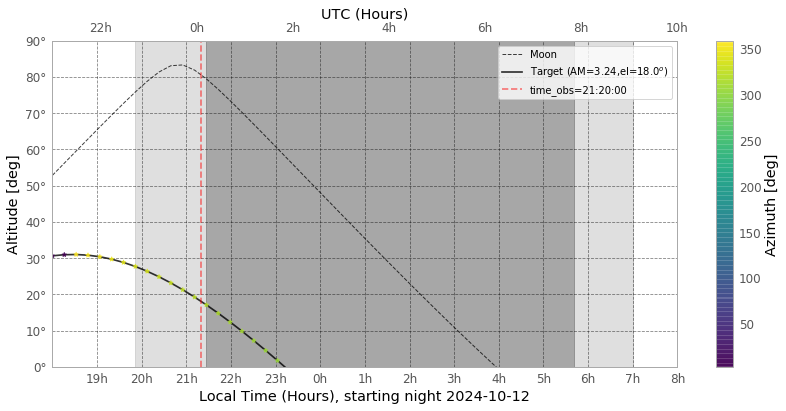

ID_HIP,URL,RA,DEC,dRA_hours,Status,SP_TYPE,Refs,FLUX_B,FLUX_V,FLUX_J,FLUX_H,FLUX_K,Sep_deg
HIP 88429,Simbad,18:03:14.56,+19:36:47.36,-0.07,Before Science,A0V,58,6.45,6.42,6.28,6.27,6.28,9.20
HIP 88983,Simbad,18:09:44.78,+04:36:11.23,0.04,After Science,A1V,26,7.96,7.75,7.30,7.19,7.18,24.17


In [9]:
#####
# Set parameters
#####
#
# Standard parameters (do not bother to modify them!)
#
# set the number of decimals you want to print
n_digits = 2
# show the results as a HTML table (best option!)
html = True
# show hyperlink for Simbad (useful for quick-check i the sources are isolated, binaries or something else!)
show_url = True

#
# Specific parameters (change them accordingly to your observing strategy)
#
# show the visibility plot (True or False)
plot_visibility = True
# set the magnitude range you are looking for
# define the filter to set the magnitude range (It works for any if the BVRIJHK filters)
band = 'K'
# (you might want to avoid really bright sources that will quickly saturate, and real faint objects that will require longer exposures)
mag_lim = [4.0,8.50]

# set the duration of your observations (in hours)
max_hour = 0.1
# set the maximum separation between your target and the telluric standard (in degrees)
max_sep = 25

#set date at the start of the night
date_obs = '2024-10-12'

localtime_obs = None
localtime_obs = '21:20:00'
#localtime_obs = 'Now'

# finally, set the coordinates of your target
coords = '15:11:56.07   -48:44:16.17'
coords = '18:07:32.55   +28:45:44.96'

# set the maximum airmass difference between telluric standard and science target. 'None' will display all results
dairmass=0.15

# now run the script
find_telluric(coords, max_hour=max_hour, max_sep=max_sep, band=band, AXVstars=(0,1), mag_lim=mag_lim, localtime_obs=localtime_obs,
              debug=False, n_digits=n_digits, html=html, show_url=show_url, date_obs=date_obs, dairmass=dairmass, plot_visibility=plot_visibility)